<a href="https://colab.research.google.com/github/knuteriksen/VisionPorComputador/blob/main/CarModel_Full.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-efcb66bc-a049-83e0-5ba9-429132a6352b)


In [ ]:
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Lambda
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization as BN
from keras.layers import GaussianNoise as GN
from keras.optimizers import SGD, Adam
from keras.models import Model
from keras.callbacks import LearningRateScheduler as LRS
from keras.callbacks import Callback
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tensorflow.keras.utils import plot_model

import os

plt.rcParams["figure.figsize"] = (15,15)

In [ ]:
batch_size = 32
num_classes = 20
primary_epochs = 220
secondary_epochs = 110

In [ ]:
# Download: ONLY ONCE!
os.system('wget https://www.dropbox.com/s/sakfqp6o8pbgasm/data.tgz')
os.system('tar xvzf data.tgz')


0

In [ ]:
def outer_product(x):
  phi_I = tf.einsum('ijkm,ijkn->imn', x[0], x[1])		# Einstein Notation  [batch,31,31,depth] x [batch,31,31,depth] -> [batch,depth,depth]
  phi_I = tf.reshape(phi_I,[-1,512*512])	          # Reshape from [batch_size,depth,depth] to [batch_size, depth*depth]
  phi_I = tf.divide(phi_I,7*7)							  	  # Divide by feature map size [size * size]

  y_ssqrt = tf.multiply(                            # Take signed square root of phi_I
      tf.sign(phi_I),
      tf.sqrt(tf.abs(phi_I)+1e-12)
      )
  
  z_l2 = tf.nn.l2_normalize(y_ssqrt)							  # Apply l2 normalization
  
  return z_l2

datagen = ImageDataGenerator(
  width_shift_range=0.2,
  height_shift_range=0.2,
  rotation_range=20,
  zoom_range=[1.0,1.2],
  horizontal_flip=True
  )

def multiple_data_generator(generator, X,Y,bs):
    genX = generator.flow(X, Y, batch_size=bs)
    while True:
      [Xi,Yi] = genX.next()
      yield [Xi,Xi],Yi

def scheduler(epoch):
    if epoch < primary_epochs*3/4:
        return 0.1
    else:
        return 0.01
    
set_lr = LRS(scheduler)

class PlotLearning(Callback):
    def on_train_begin(self, logs={}):
        plt.rcParams["figure.figsize"] = (15,10)
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        plt.rcParams["figure.figsize"] = (15,10)
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('accuracy'))
        self.val_acc.append(logs.get('val_accuracy'))
        self.i += 1
        f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
        
        clear_output(wait=True)
        
        ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="loss")
        ax1.plot(self.x, self.val_losses, label="val_loss")
        ax1.legend()
        
        ax2.plot(self.x, self.acc, label="accuracy")
        ax2.plot(self.x, self.val_acc, label="validation accuracy")
        ax2.legend()
        
        plt.show();
        
plot_callback = PlotLearning()

In [ ]:
x_train = np.load('x_train.npy')
x_test = np.load('x_test.npy')

y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

y_train=y_train-1
y_test=y_test-1

y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

x_train = keras.applications.vgg16.preprocess_input(x_train)
x_test = keras.applications.vgg16.preprocess_input(x_test)

In [ ]:
base_model_1 = VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=x_train.shape[1:]
)

for layer in base_model_1.layers:
  layer._name = layer._name + str('_1')
  layer.trainable = False;

base_model_1.summary();


base_model_2 = VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=x_train.shape[1:]
)

for layer in base_model_2.layers:
  layer._name = layer._name + str('_2')
  layer.trainable = False;

base_model_2.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1_1 (InputLayer)       [(None, 250, 250, 3)]     0         
_________________________________________________________________
block1_conv1_1 (Conv2D)      (None, 250, 250, 64)      1792      
_________________________________________________________________
block1_conv2_1 (Conv2D)      (None, 250, 250, 64)      36928     
_________________________________________________________________
block1_pool_1 (MaxPooling2D) (None, 125, 125, 64)      0         
_________________________________________________________________
block2_conv1_1 (Conv2D)      (None, 125, 125, 128)     73856     
_________________________________________________________________
block2_conv2_1 (Conv2D)      (None, 125, 125, 128)     147584    
______________________________________________________________

In [ ]:
conv_1 = base_model_1.get_layer('block5_pool_1').output
d1 = Dropout(0.5)(conv_1)

conv_2 = base_model_2.get_layer('block5_pool_2').output
d2 = Dropout(0.5)(conv_2)

x = Lambda(outer_product, name='outer_product')([d1,d2])

predictions=Dense(num_classes, activation='softmax', name='predictions')(x)

model = Model(inputs=[base_model_1.input, base_model_2.input], outputs=predictions)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.0001),
              metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1_1 (InputLayer)          [(None, 250, 250, 3) 0                                            
__________________________________________________________________________________________________
input_2_2 (InputLayer)          [(None, 250, 250, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1_1 (Conv2D)         (None, 250, 250, 64) 1792        input_1_1[0][0]                  
__________________________________________________________________________________________________
block1_conv1_2 (Conv2D)         (None, 250, 250, 64) 1792        input_2_2[0][0]                  
______________________________________________________________________________________________

In [ ]:

history1=model.fit(x=multiple_data_generator(datagen, x_train, y_train, batch_size),
                  epochs=primary_epochs,
                  steps_per_epoch = len(x_train) / batch_size,
                  validation_data=([x_test, x_test], y_test),
                  verbose=1
)


Epoch 1/220
24/24 [==============================] - 90s 2s/step - loss: 2.9953 - accuracy: 0.0647 - val_loss: 2.9915 - val_accuracy: 0.1620
Epoch 2/220
24/24 [==============================] - 20s 822ms/step - loss: 2.9908 - accuracy: 0.1205 - val_loss: 2.9868 - val_accuracy: 0.1033
Epoch 3/220
24/24 [==============================] - 20s 838ms/step - loss: 2.9867 - accuracy: 0.1262 - val_loss: 2.9823 - val_accuracy: 0.1276
Epoch 4/220
24/24 [==============================] - 21s 857ms/step - loss: 2.9817 - accuracy: 0.1426 - val_loss: 2.9780 - val_accuracy: 0.1378
Epoch 5/220
24/24 [==============================] - 21s 850ms/step - loss: 2.9777 - accuracy: 0.1575 - val_loss: 2.9737 - val_accuracy: 0.1403
Epoch 6/220
24/24 [==============================] - 20s 842ms/step - loss: 2.9722 - accuracy: 0.1824 - val_loss: 2.9694 - val_accuracy: 0.1543
Epoch 7/220
24/24 [==============================] - 22s 904ms/step - loss: 2.9701 - accuracy: 0.1800 - val_loss: 2.9651 - val_accuracy: 0.

In [ ]:
for layer in base_model_1.layers:
  layer.trainable = True

for layer in base_model_2.layers:
  layer.trainable = True

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.00001),
              metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1_1 (InputLayer)          [(None, 250, 250, 3) 0                                            
__________________________________________________________________________________________________
input_2_2 (InputLayer)          [(None, 250, 250, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1_1 (Conv2D)         (None, 250, 250, 64) 1792        input_1_1[0][0]                  
__________________________________________________________________________________________________
block1_conv1_2 (Conv2D)         (None, 250, 250, 64) 1792        input_2_2[0][0]                  
______________________________________________________________________________________________

In [ ]:

history2=model.fit(x=multiple_data_generator(datagen, x_train, y_train, batch_size),
                  epochs=secondary_epochs,
                  steps_per_epoch = len(x_train) / batch_size,                 
                  validation_data=([x_test, x_test], y_test),
                  verbose=1
)

Epoch 1/110
24/24 [==============================] - 52s 2s/step - loss: 2.2411 - accuracy: 0.5902 - val_loss: 2.1637 - val_accuracy: 0.4464
Epoch 2/110
24/24 [==============================] - 37s 1s/step - loss: 2.1321 - accuracy: 0.6077 - val_loss: 2.0752 - val_accuracy: 0.4579
Epoch 3/110
24/24 [==============================] - 37s 2s/step - loss: 2.0088 - accuracy: 0.6239 - val_loss: 2.0231 - val_accuracy: 0.4656
Epoch 4/110
24/24 [==============================] - 37s 2s/step - loss: 1.9628 - accuracy: 0.6212 - val_loss: 1.9844 - val_accuracy: 0.4605
Epoch 5/110
24/24 [==============================] - 37s 2s/step - loss: 1.9042 - accuracy: 0.6152 - val_loss: 1.9260 - val_accuracy: 0.4885
Epoch 6/110
24/24 [==============================] - 37s 2s/step - loss: 1.8696 - accuracy: 0.6317 - val_loss: 1.8941 - val_accuracy: 0.4949
Epoch 7/110
24/24 [==============================] - 37s 1s/step - loss: 1.8422 - accuracy: 0.6642 - val_loss: 1.8609 - val_accuracy: 0.4962
Epoch 8/110
2

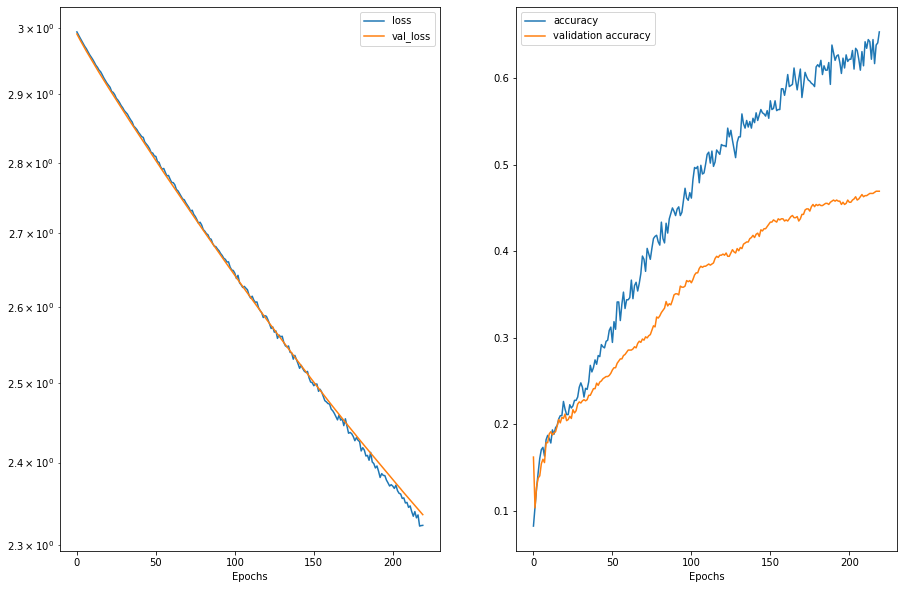

In [ ]:
plt.rcParams["figure.figsize"] = (15,10)

f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
ax1.set_yscale('log')
ax1.plot(history1.history['loss'], label="loss")
ax1.plot(history1.history['val_loss'], label="val_loss")
ax1.legend()

ax2.plot(history1.history['accuracy'], label="accuracy")
ax2.plot(history1.history['val_accuracy'], label="validation accuracy")
ax2.legend()

plt.setp(ax1, xlabel='Epochs')
plt.setp(ax2, xlabel='Epochs')
plt.show();

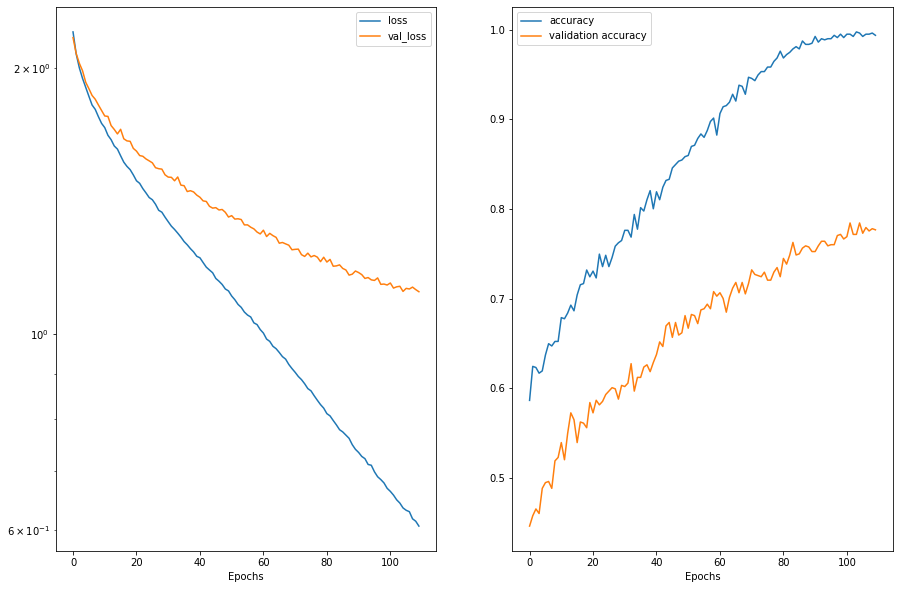

In [ ]:
plt.rcParams["figure.figsize"] = (15,10)

f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
ax1.set_yscale('log')
ax1.plot(history2.history['loss'], label="loss")
ax1.plot(history2.history['val_loss'], label="val_loss")
ax1.legend()

ax2.plot(history2.history['accuracy'], label="accuracy")
ax2.plot(history2.history['val_accuracy'], label="validation accuracy")
ax2.legend()

plt.setp(ax1, xlabel='Epochs')
plt.setp(ax2, xlabel='Epochs')
plt.show();